#Amazon Fine Food Sentiment Analysis

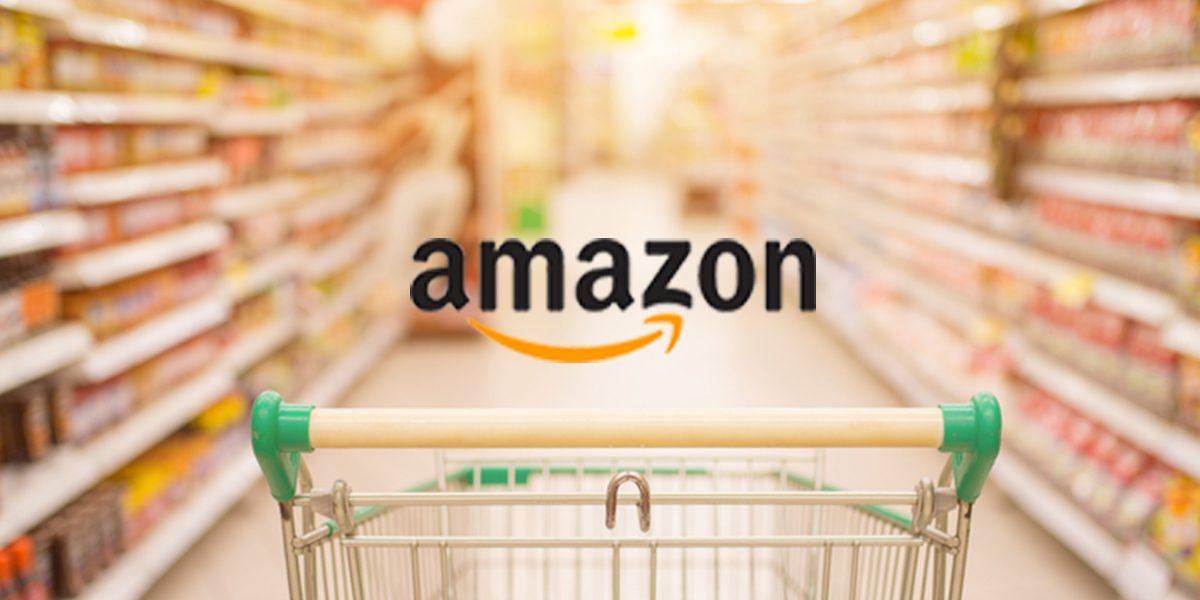https://d3pc1xvrcw35tl.cloudfront.net/images/1200x900/amazon-future-deal-4_202103584688.jpg

###Import neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.preprocessing import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, SimpleRNN, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

###Load Dataset

In [2]:
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
csv_file = os.path.join(path, "Reviews.csv")
df = pd.read_csv(csv_file)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.


In [3]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


###Exploratory Data Analysis

In [4]:
df.isna().sum().sum()

np.int64(53)

In [5]:
df.dropna(inplace=True)

In [6]:
df_clean = df[['Text', 'Score']]
score_counts = df_clean['Score'].value_counts().sort_index()
score_counts

,count
Score,
1,52264
2,29743
3,42638
4,80654
5,363102


###Insights

In [7]:
for score, count in score_counts.items():
  percentage = (count/len(df_clean)*100)
  print(f"{score} Stars : {percentage:.2f}%")

1 Stars : 9.19%
2 Stars : 5.23%
3 Stars : 7.50%
4 Stars : 14.19%
5 Stars : 63.88%


In [8]:
for score in range(1, 6):
  sample_reviews = df_clean[df_clean['Score']==score]['Text'].iloc[0]
  print(f"\n{score} - Star Reviews")
  print(sample_reviews)


1 - Star Reviews
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

2 - Star Reviews
If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.

3 - Star Reviews
This seems a little more wholesome than some of the supermarket brands, but it is somewhat mushy and doesn't have quite as much flavor either.  It didn't pass muster with my kids, so I probably won't buy it again.

4 - Star Reviews
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recomme

###Data Cleaning

In [9]:
df_clean['text_length'] = df_clean['Text'].str.len()
df_clean['word_count'] = df_clean['Text'].str.split().str.len()

/tmp/ipython-input-1053056101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['text_length'] = df_clean['Text'].str.len()
/tmp/ipython-input-1053056101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['word_count'] = df_clean['Text'].str.split().str.len()


In [10]:
df_clean

,Text,Score,text_length,word_count
0,I have bought several of the Vitality canned d...,5,263,48
1,Product arrived labeled as Jumbo Salted Peanut...,1,190,31
2,This is a confection that has been around a fe...,4,509,94
3,If you are looking for the secret ingredient i...,2,219,41
4,Great taffy at a great price. There was a wid...,5,140,27
...,...,...,...,...
568449,Great for sesame chicken..this is a good if no...,5,149,26
568450,I'm disappointed with the flavor. The chocolat...,2,252,46
568451,"These stars are small, so you can give 10-15 o...",5,372,66
568452,These are the BEST treats for training and rew...,5,200,35


###Data Visualization

<Axes: xlabel='Score'>

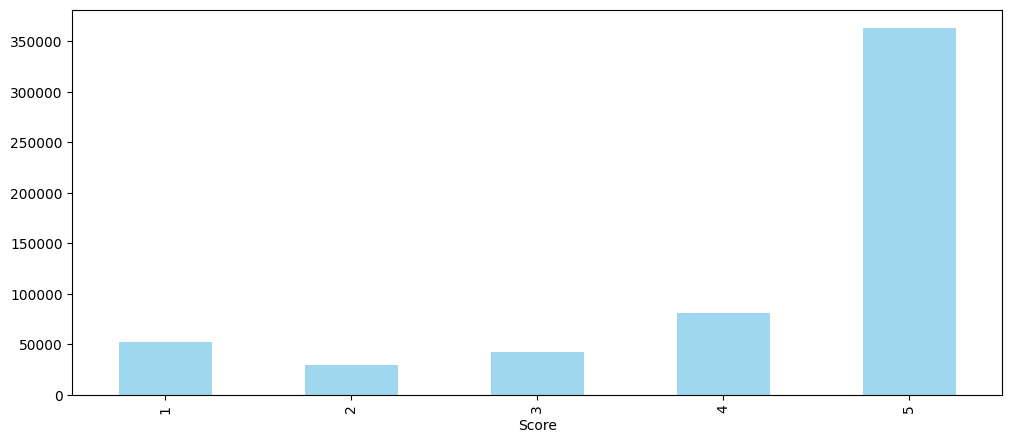

In [11]:
plt.figure(figsize=(12,5))
score_counts.plot(kind='bar', color='skyblue', alpha=0.8)

Text(0, 0.5, 'Frequency')

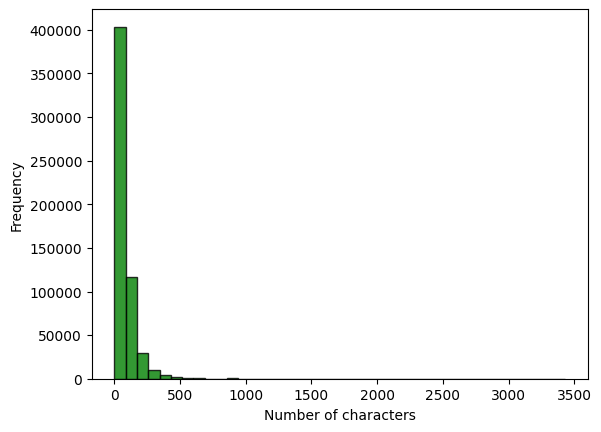

In [12]:
plt.hist(df_clean['word_count'], bins=40, alpha=0.8, color='green', edgecolor='black')
plt.xlabel("Number of characters")
plt.ylabel("Frequency")

###Data Preparation

In [13]:
df_binary = df_clean[df_clean['Score']!=3].copy()
df_binary['sentiment'] = (df_binary['Score']>=4).astype(int)

In [14]:
df_binary.head(5)

,Text,Score,text_length,word_count,sentiment
0,I have bought several of the Vitality canned d...,5,263,48,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,190,31,0
2,This is a confection that has been around a fe...,4,509,94,1
3,If you are looking for the secret ingredient i...,2,219,41,0
4,Great taffy at a great price. There was a wid...,5,140,27,1


In [15]:
print(f"Original Data : {len(df_clean):} reviews")
print(f"After removing 3-star reviews: {len(df_binary):} reviews")
diff = (len(df_clean) - len(df_binary))
print(f"{diff} reviews were removed")

Original Data : 568401 reviews
After removing 3-star reviews: 525763 reviews
42638 reviews were removed


In [16]:
print("CLASS DISTRIBUTION")
print(f"Negative (1-2 stars): {sum(df_binary['sentiment'] == 0):,}")
print(f"Positive (4-5 stars): {sum(df_binary['sentiment'] == 1):,}")

neg_pct = (sum(df_binary['sentiment'] == 0) / len(df_binary)) * 100
pos_pct = (sum(df_binary['sentiment'] == 1) / len(df_binary)) * 100
print(f"Class imbalnce in percentage\n")
print(f"Negative : {neg_pct:.2f}%")
print(f"Positive : {pos_pct:.2f}%")

CLASS DISTRIBUTION
Negative (1-2 stars): 82,007
Positive (4-5 stars): 443,756
Class imbalnce in percentage

Negative : 15.60%
Positive : 84.40%


###Handling Class Imbalance

In [17]:
neg_rev = df_binary[df_binary['sentiment']==0]
pos_rev = df_binary[df_binary['sentiment']==1]

pos_downsamp = resample(pos_rev, replace=False, n_samples=len(neg_rev), random_state=42)

df_balanced = pd.concat([neg_rev, pos_downsamp])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
print(f"After balancing :\n")
print(f"Total sample size: {len(df_balanced)}")
print(f"Negative : {sum(df_balanced['sentiment'] == 0):,} ({sum(df_balanced['sentiment'] == 0)/len(df_balanced)*100})")
print(f"Positive : {sum(df_balanced['sentiment'] == 1):,} ({sum(df_balanced['sentiment'] == 1)/len(df_balanced)*100})")

After balancing :

Total sample size: 164014
Negative : 82,007 (50.0)
Positive : 82,007 (50.0)


In [19]:
df_sample = df_balanced.sample(n = 50000, random_state=42)
samp_neg = sum(df_sample['sentiment']==0)
samp_pos = sum(df_sample['sentiment']==1)
print(f"Negative : {samp_neg:,} ({samp_neg/len(df_sample)*100}%)")
print(f"Positive : {samp_pos:,} ({samp_pos/len(df_sample)*100}%)")

Negative : 25,031 (50.062%)
Positive : 24,969 (49.938%)


###Text Cleaning

>Convert all letters to lowercase

>Remove any special characters from data  @, encodeing, numnbers.Keep only letters and spaces

>Remove extra whitespace

In [20]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  return " ".join(text.split())

In [21]:
df_sample['clean_text'] = df_sample['Text'].apply(clean_text)
print(f"Original Text : '''{df_sample['Text'][0]}'''")
print(f"Clean Text : '''{df_sample['clean_text'][0]}'''")
df_sample.head(2)

Original Text : '''I found this Harissa Paste somewhat overpowering as compared to others that I have tried.  Though a subjective matter, it was not to my taste and I ended up throwing away half a jar.'''
Clean Text : '''i found this harissa paste somewhat overpowering as compared to others that i have tried though a subjective matter it was not to my taste and i ended up throwing away half a jar'''


,Text,Score,text_length,word_count,sentiment,clean_text
18418,Sea's Gift Korean Seaweed Snack Sweet. Not tha...,2,107,20,0,seas gift korean seaweed snack sweet not that ...
70861,fYI: entire package = about 1 cup of stew. No...,5,586,106,1,fyi entire package about cup of stew not that ...


###Tokenization

In [22]:
x = df_sample['clean_text'].values
y = df_sample['sentiment'].values

In [23]:
max_features = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(x)

x_sequences = tokenizer.texts_to_sequences(x)
x_padded = pad_sequences(x_sequences, maxlen=max_len, padding='post', truncating='post')

print(f"Original Text : '{x[0][:100]}")
print(f"Sequence : '{x_sequences[0][:100]}")

Original Text : 'seas gift korean seaweed snack sweet not that good way over priced for what you get will not buy aga
Sequence : '[1, 523, 4337, 2980, 287, 138, 15, 13, 37, 123, 133, 1055, 12, 69, 20, 61, 50, 15, 79, 106]


###Split the data into Train and Test Parts

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    x_padded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

###RNN Model Building

In [25]:
def create_rnn_model():
  model = Sequential([
      Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
      SimpleRNN(units=64, return_sequences=False),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  return model

In [26]:
rnn_model = create_rnn_model()
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [27]:
rnn_history = rnn_model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2
)

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(rnn_history.history['loss'],label='Training Loss')
plt.plot(rnn_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(rnn_history.history['accuracy'],label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

###LSTM Model Building

In [29]:
def create_lstm_model():
  model = Sequential([
      Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
      LSTM(units=64, return_sequences=False),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  return model

In [30]:
lstm_model = create_lstm_model()
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

lstm_history = lstm_model.fit(
    x_train, y_train,
    epochs = 10,
    batch_size=128,
    validation_split=0.20
)

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'],label='Training Loss')
plt.plot(lstm_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['accuracy'],label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

###Hyperparameter Tuning

In [32]:
param_grid = {
    'model_type':['rnn', 'lstm'],
    'embedding_dim':[64, 128],
    'units':[32,64,128],
    'dropout_rate':[0.3,0.5],
    'learning_rate':[0.001,0.01]
}

In [33]:
def create_model_with_params(model_type='lstm', embedding_dim=128, units=64, dropout_rate=0.5, learning_rate = 0.001):
  model = Sequential([
      Embedding(max_features, embedding_dim, input_length=max_len)
  ])
  if model_type=='lstm':
    model.add(LSTM(units, return_sequences=False))
  else:
    model.add(SimpleRNN(units, return_sequences=False))

  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [36]:
def random_search(n_trials=8):
  res = []
  np.random.seed(42)
  print(f"Testing {n_trials} random parameters.....")
  for i in range(n_trials):
    params = {
        'model_type':str(np.random.choice(param_grid['model_type'])),
        'embedding_dim':int(np.random.choice(param_grid['embedding_dim'])),
        'units': int(np.random.choice(param_grid['units'])),
        'dropout_rate':float(np.random.choice(param_grid['dropout_rate'])),
        'learning_rate':float(np.random.choice(param_grid['learning_rate']))
    }
    try:
      model = create_model_with_params(**params)
      history = model.fit(
          x_train, y_train,
          batch_size = 64,
          epochs = 15,
          validation_split=0.2
      )
      val_acc = max(history.history['val_accuracy'])
      res.append({
          'trial':i+1,
          'params':params,
          'val_acc':val_acc,
          'model':model
      })
      print(f"Validation Accuracy : {val_acc}")
    except Exception as e:
      print(f"Error : {str(e)}")
      continue
  return res

In [37]:
search_res = random_search(8)

Testing 8 random parameters.....
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.5260 - loss: 0.6909 - val_accuracy: 0.5138 - val_loss: 0.6900
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.5390 - loss: 0.6832 - val_accuracy: 0.5351 - val_loss: 0.6850
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.6124 - loss: 0.6148 - val_accuracy: 0.5425 - val_loss: 0.7186
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.6699 - loss: 0.5239 - val_accuracy: 0.5511 - val_loss: 0.8163
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.7131 - loss: 0.4690 - val_accuracy: 0.5548 - val_loss: 0.9435
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.7534 - loss: 0.4284 - val_accuracy: 0.5699 - val_loss: 1.0253
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.7829 - loss: 0.4007 - val_accuracy: 0.5680 - val_loss: 1.0837
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8490 - loss: 0.3192 - val_accurac

In [39]:
if search_res:
  best_res = max(search_res, key=lambda x:x['val_acc'])
  print(f"Random Search Results\n")
  for res in search_res:
    trial = res['trial']
    acc = res['val_acc']
    model_type = res['params']['model_type']
  print("\nBest Configuration\n")
  print(f"Trail : {best_res['trial']}")
  print(f"Parametres : {best_res['params']}")
  print(f"Validation Accuracy : {best_res['val_acc']}")

Random Search Results


Best Configuration

Trail : 2
Parametres : {'model_type': 'lstm', 'embedding_dim': 64, 'units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Validation Accuracy : 0.8853750228881836


In [41]:
if search_res:
    best_res = max(search_res, key=lambda x: x['val_acc'])
    best_params = best_res['params']
    print(best_params)

    best_model = create_model_with_params(**best_params)

    callbacks = [
        ModelCheckpoint(
            "best_model_sentiment.h5",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]

    final_his = best_model.fit(
        x_train, y_train,
        batch_size=64,
        epochs=35,
        validation_split=0.2,
        callbacks=callbacks
    )


{'model_type': 'lstm', 'embedding_dim': 64, 'units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/35
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5706 - loss: 0.6512

500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - accuracy: 0.5708 - loss: 0.6510 - val_accuracy: 0.8546 - val_loss: 0.3630
Epoch 2/35
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8861 - loss: 0.3006

500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8861 - loss: 0.3006 - val_accuracy: 0.8737 - val_loss: 0.2961
Epoch 3/35
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9249 - loss: 0.2030

500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.9249 - loss: 0.2030 - val_accuracy: 0.8852 - val_loss: 0.2858
Epoch 4/35
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9423 - loss: 0.1619 - val_accuracy: 0.8764 - val_loss: 0.3221
Epoch 5/35
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9497 - loss: 0.1395 - val_accuracy: 0.8829 - val_loss: 0.3641
Epoch 6/35
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9601 - loss: 0.1120 - val_accuracy: 0.8811 - val_loss: 0.3810


###Save the Tokenizer

In [42]:
import pickle
with open('amazon_sentiment_tokenizer.pkl', "wb") as f:
  pickle.dump(tokenizer, f)

###Load the Best Model and Tokenizer

In [46]:
from tensorflow.keras.models import load_model
loaded_model = load_model("best_model_sentiment.h5")
with open("amazon_sentiment_tokenizer.pkl", "rb") as f:
  loaded_tokenizer = pickle.load(f)

###Make Predictions

In [47]:
test_sentences = [
    "The product quality is amazing, totally worth the price!",
    "I’m extremely disappointed — it broke after just two days.",
    "Delivery was fast, but the packaging was damaged.",
    "Absolutely love it! Works better than I expected.",
    "It’s okay, not great but not too bad either.",
    "Customer service was terrible, they never replied to my emails.",
    "I’m thrilled with this purchase, it made my day!",
    "The product doesn’t match the description at all.",
    "Pretty decent overall, though it could be improved slightly.",
    "Hands down one of the best products I’ve ever used!"
]

In [48]:
def predict_sentiment(text):
  clean = clean_text(text)
  seq = loaded_tokenizer.texts_to_sequences([clean])
  padded = pad_sequences(seq, maxlen = max_len, padding='post')
  prob = loaded_model.predict(padded)[0][0]
  sentiment = "Positive" if prob>0.5 else "Negative"
  return sentiment, prob

In [50]:
for sentence in test_sentences:
    sentiment, prob = predict_sentiment(sentence)
    print(f"Review : {sentence}")
    print(f"Sentiment: {sentiment}, Probability: {prob:.4f}")
    print("==============================================")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Review : The product quality is amazing, totally worth the price!
Sentiment: Positive, Probability: 0.9808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Review : I’m extremely disappointed — it broke after just two days.
Sentiment: Negative, Probability: 0.0828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Review : Delivery was fast, but the packaging was damaged.
Sentiment: Positive, Probability: 0.9513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Review : Absolutely love it! Works better than I expected.
Sentiment: Positive, Probability: 0.9886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Review : It’s okay, not great but not too bad either.
Sentiment: Negative, Probability: 0.0566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Review : Customer service was terrible, they never replied to my emails.
Sentiment: Negative, Probability: 0.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Review : I’m thrilled with this purchase, it made my day!
Sentiment: Positive, Probability: 0.9747
1/1 ━━━━━━